In [4]:
import pandas as pd

df = pd.read_csv('versionInfo.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 11 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   filename                                      8 non-null      object
 1   version                                       8 non-null      object
 2   url                                           8 non-null      object
 3   description                                   8 non-null      object
 4   Type                                          8 non-null      object
 5   Associations with external schemes            8 non-null      object
 6   Available associations with external schemes  5 non-null      object
 7   Presence of controls/metrics                  8 non-null      object
 8   Number of controls/metrics                    8 non-null      int64 
 9   Association with old data                     3 non-null      object
 10  Associ

In [5]:
# Lista delle colonne da mantenere
cols_to_keep = [
    'filename',
    'Type',
    'Available associations with external schemes',
    'Number of controls/metrics',
    'Association with old data',
    'Association with new data'
]

# Crea il nuovo dataframe filtrato
df = df[cols_to_keep]


df

,filename,Type,Available associations with external schemes,Number of controls/metrics,Association with old data,Association with new data
0,Cisco.csv,Controls,"SpanishENS.csv, NewEucsRequirements.csv, Secnu...",713,NaN,"SpanishENS.csv, NewEucsRequirements.csv, Secnu..."
1,NewEucsRequirements.csv,Controls,"BSI-C5.json, Secnumcloud.csv\n",120,BSI-C5.json,Secnumcloud.csv\nBSI-C5.json
2,SpanishENS.csv,Controls,NaN,209,NaN,NaN
3,BSI-C5.json,Controls,OldEucsRequirements.csv,294,OldEucsRequirements.csv,NaN
4,Secnumcloud.csv,Controls,NaN,287,NaN,NaN
5,medinaMetrics.csv,Metrics,OldEucsRequirements.csv,166,OldEucsRequirements.csv,NaN
6,OldEucsRequirements.csv,Controls,NaN,70,NaN,NaN
7,fabasoftMetrics.csv,Metrics,"OldEucsRequirements.csv, BSI-C5.json",57,NaN,"NewEucsRequirements.csv, BSI-C5.json"


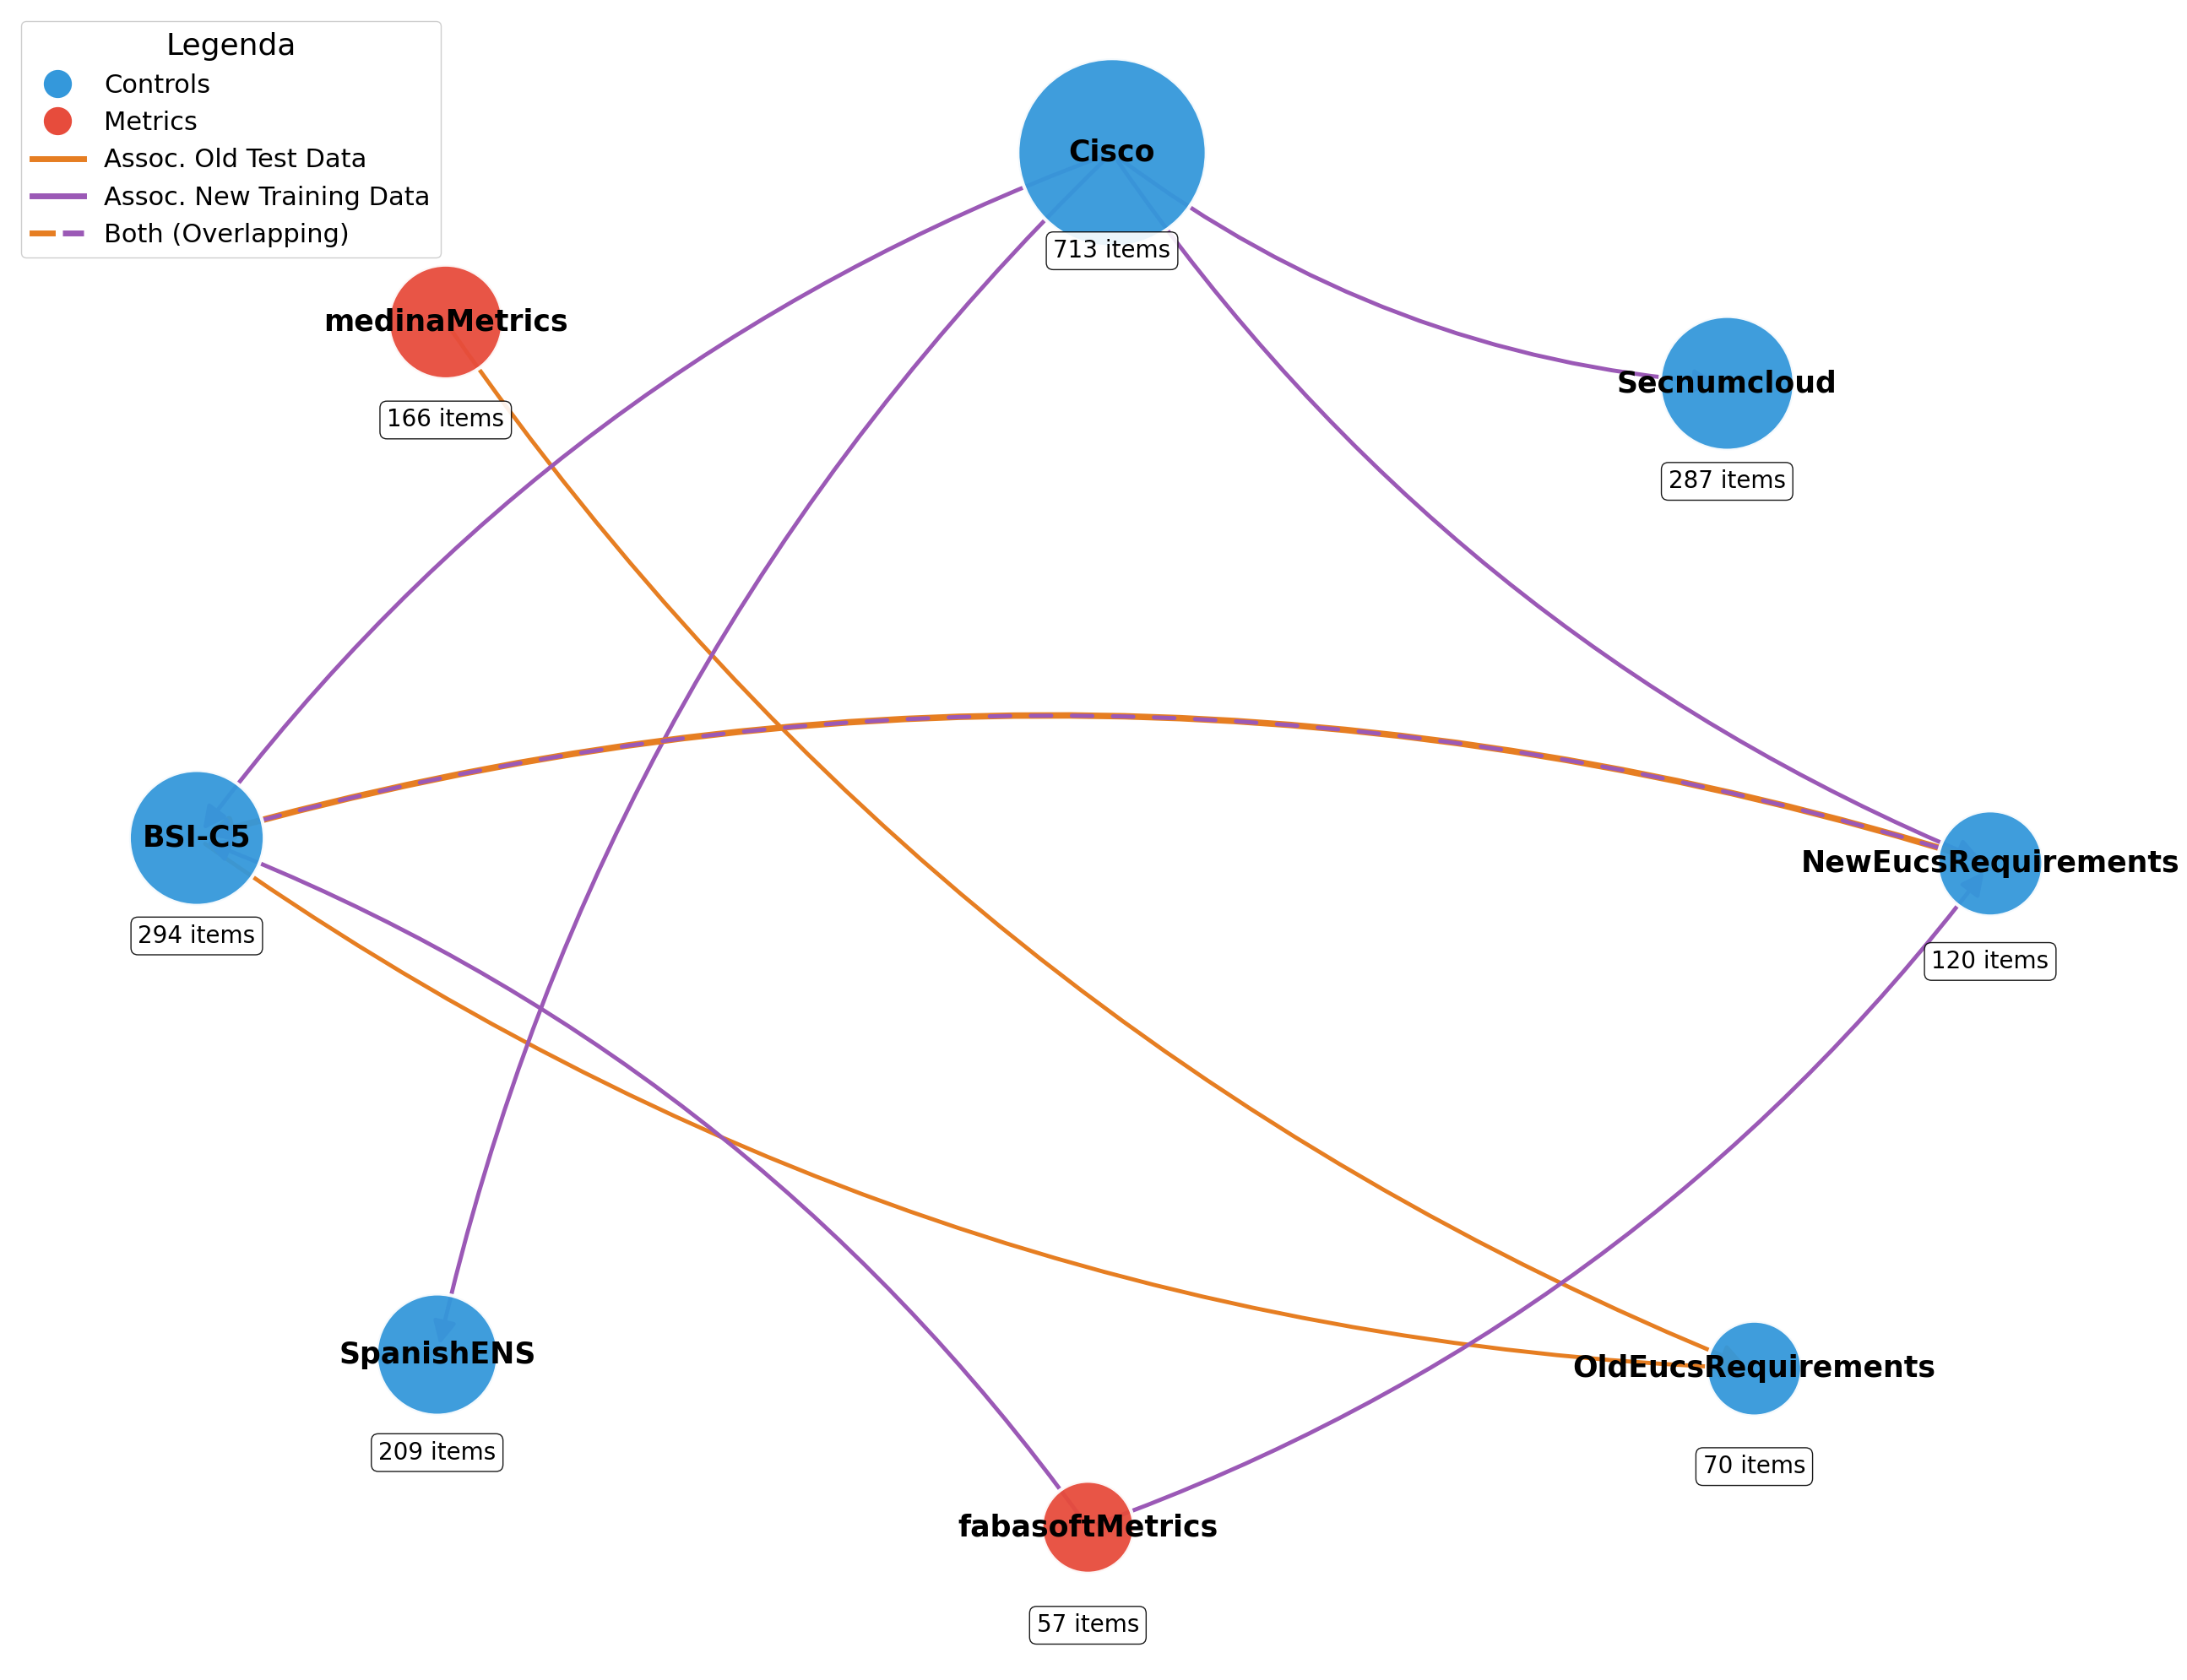

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

# Assumiamo che il tuo dataframe si chiami 'df'
df = df.fillna('')

G = nx.DiGraph()

# 1. AGGIUNTA DEI NODI
for idx, row in df.iterrows():
    filename = row['filename']
    node_type = row['Type']
    try:
        n_controls = int(row['Number of controls/metrics']) if row['Number of controls/metrics'] != '' else 10
    except:
        n_controls = 10
    
    G.add_node(filename, type=node_type, n_controls=n_controls)

# 2. AGGIUNTA DEGLI ARCHI CON CLASSIFICAZIONE
COLOR_OLD = '#e67e22' # Arancio
COLOR_NEW = '#9b59b6' # Viola

def add_edges_from_column(graph, dataframe, source_node, column_name, category_tag):
    associations = dataframe.loc[dataframe['filename'] == source_node, column_name].values[0]
    
    if associations and str(associations).lower() != 'nan':
        target_list = [t.strip() for t in str(associations).split(',')]
        for target_partial_name in target_list:
            if not target_partial_name: continue
            
            # Fuzzy match
            matched_target = None
            for candidate in dataframe['filename']:
                if target_partial_name in candidate or candidate in target_partial_name:
                    matched_target = candidate
                    break
            
            if matched_target:
                # Logica "Both"
                if graph.has_edge(source_node, matched_target):
                    current_tag = graph[source_node][matched_target].get('tag')
                    if current_tag != category_tag:
                        graph[source_node][matched_target]['tag'] = 'both'
                else:
                    graph.add_edge(source_node, matched_target, tag=category_tag)

# Aggiungiamo gli archi
for idx, row in df.iterrows():
    source = row['filename']
    add_edges_from_column(G, df, source, 'Association with old data', 'old')
    add_edges_from_column(G, df, source, 'Association with new data', 'new')

# 3. CONFIGURAZIONE VISUALIZZAZIONE
fig, ax = plt.subplots(figsize=(26, 20)) 

pos = nx.spring_layout(G, k=10, iterations=100, seed=42)

color_map_nodes = {
    'Controls': '#3498db',
    'Metrics': '#e74c3c',
    'Requirements': '#2ecc71',
}
node_colors = [color_map_nodes.get(G.nodes[node].get('type', 'Other'), '#95a5a6') for node in G.nodes()]

# Dimensioni Nodi (Base 4500 per testo grande)
node_sizes = [G.nodes[node]['n_controls'] * 30 + 4500 for node in G.nodes()]

# --- DISEGNO DEGLI ARCHI ---

edges_old = [(u, v) for u, v, d in G.edges(data=True) if d.get('tag') == 'old']
edges_new = [(u, v) for u, v, d in G.edges(data=True) if d.get('tag') == 'new']
edges_both = [(u, v) for u, v, d in G.edges(data=True) if d.get('tag') == 'both']

arrow_style = '-|>'
arrow_size = 40
conn_style = 'arc3,rad=0.15'
line_width = 3.5

# 1. Disegna Old (Arancio)
nx.draw_networkx_edges(G, pos, edgelist=edges_old, edge_color=COLOR_OLD, 
                       arrows=True, arrowsize=arrow_size, arrowstyle=arrow_style, 
                       width=line_width, connectionstyle=conn_style, ax=ax)

# 2. Disegna New (Viola)
nx.draw_networkx_edges(G, pos, edgelist=edges_new, edge_color=COLOR_NEW, 
                       arrows=True, arrowsize=arrow_size, arrowstyle=arrow_style, 
                       width=line_width, connectionstyle=conn_style, ax=ax)

# 3. Disegna BOTH (Doppia Linea: Arancio sotto + Viola tratteggiato sopra)
# Layer Sotto (Arancio Solido)
nx.draw_networkx_edges(G, pos, edgelist=edges_both, edge_color=COLOR_OLD, 
                       arrows=True, arrowsize=arrow_size, arrowstyle=arrow_style, 
                       width=line_width+2, connectionstyle=conn_style, ax=ax)

# Layer Sopra (Viola Tratteggiato)
nx.draw_networkx_edges(G, pos, edgelist=edges_both, edge_color=COLOR_NEW, 
                       arrows=True, arrowsize=arrow_size, arrowstyle=arrow_style, 
                       width=line_width, connectionstyle=conn_style, style=(0, (5, 5)), ax=ax)

# --- DISEGNO NODI E TESTI ---

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                       alpha=0.95, ax=ax, edgecolors='white', linewidths=3)

# Etichette (Font 35)
labels = {node: node.replace('.csv', '').replace('.json', '')[:25] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=25, font_weight='bold', ax=ax)

# Annotazioni sotto i nodi
for node, (x, y) in pos.items():
    info = G.nodes[node]
    text = f"{info['n_controls']} items"
    ax.text(x, y-0.15, text, fontsize=20, ha='center', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

# 4. LEGENDA CORRETTA CON EFFETTO BICOLORE REALE
from matplotlib.lines import Line2D

# Definiamo i nodi
legend_nodes = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=25, label='Controls'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=25, label='Metrics'),
]

# Definiamo le linee base
line_old = Line2D([0], [0], color=COLOR_OLD, lw=5, label='Assoc. Old Data')
line_new = Line2D([0], [0], color=COLOR_NEW, lw=5, label='Assoc. New Data')

# --- IL TRUCCO PER LA LEGENDA BICOLORE ---
# Creiamo due linee "fittizie" senza etichetta per comporre l'icona "Both"
# 1. La base arancione solida
line_both_base = Line2D([0], [0], color=COLOR_OLD, lw=5)
# 2. La copertura viola tratteggiata (uguale a quella usata nel grafico)
line_both_dash = Line2D([0], [0], color=COLOR_NEW, lw=5, linestyle=(0, (5, 5)))

# Componiamo la lista degli handles.
# Nota la TUPLA (line_both_base, line_both_dash): sovrappone le due linee nella legenda
legend_handles = [
    legend_nodes[0], 
    legend_nodes[1],
    line_old, 
    line_new, 
    (line_both_base, line_both_dash) # <--- Qui avviene la magia
]

# Definiamo le etichette corrispondenti
legend_labels = [
    'Controls', 
    'Metrics', 
    'Assoc. Old Test Data', 
    'Assoc. New Training Data', 
    'Both (Overlapping)'
]

ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', 
          fontsize=22, title_fontsize=26, framealpha=0.95, title="Legenda",
          handler_map={tuple: plt.matplotlib.legend_handler.HandlerTuple(ndivide=None)})

ax.axis('off')
plt.tight_layout()
plt.show()